In [1]:
import networkx as nt
import pandas as pd
from helper_functions.utilities import get_location_level

import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import warnings
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS.")
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import timedelta
from helper_functions.antenna_helper import read_antenna_data,dataframe_length_calculator,antenna_variable_histogram,antenna_aggregate_calls
from segregation_indicators.social_indicators import social_connectedness_antenna

from helper_functions.finegrained_helper import read_fine_grained,customer_signals_analysis,calculate_date_values,filter_customers,process_fine_grained
from helper_functions.tower_helper import read_tower_data,find_sites_in_buffer,plot_sites,create_point_buffer
from segregation_indicators.social_indicators import social_connectedness_antenna, ei_index
from mobility_indicators.simple_migration_flow_indicators import frequency_based_aggregation
from mobility_indicators.mobility_indicators import o_d_matrix
from helper_functions.map_helper import read_map_district
from helper_functions.utilities import get_location_level,get_suffixes_based_on_direction,apply_temporal_aggregation

from mobility_indicators.simple_migration_flow_indicators import daily_home_location_series

target_crs = "EPSG:32635"  # Change as per your requirement
district_maps = "/Users/bilgecagaydogdu/Desktop/Geodirectory/turkey_administrativelevels0_1_2/tur_polbnda_adm2.shp"
tower_location="/Volumes/Extreme Pro/Cell_Tower_Locations/cell_city_district.txt"
voronoi="/Volumes/Extreme Pro/Cell_Tower_Locations/turkcell_voronoi/voronoi.shp"
earthquake_cities = [42, 33, 37, 65, 2, 69, 26, 56, 48, 1]


<b> From D4R


Page 127 : 

social integration = ( Calls minority to majority  ) / (
                    (Calls minority to minority) + (Calls minority to majority))


In Turkcell data, unknown callees such as 1 to 0 or 2 to 0 etc. are usually Turkish. This is because the majority of refugees are Turkcell users. When this indicator is calculated we have to account for 0. 

Page 187:

EI index = (calls minority to majority + calls majority to minority) - (calls minority to minority + calls majority to majority) / (all types of calls)

Let's check the distribution for these indicators.

<b> Individual level social measures 

Transitivity, reciprocity, degrees 

For each call, we calculate the distance between towers and note the communication type (minority-minority) etc. 

Call frequency with other cities.



<b> How to use Markov model to predict migration ?


<h1> ANTENNA

In [2]:
df1=read_antenna_data('/Volumes/Extreme Pro/Data-CDR/Outgoing/Antenna/Antenna_202301.txt',data_type="CDR")
df2=read_antenna_data('/Volumes/Extreme Pro/Data-CDR/Outgoing/Antenna/Antenna_202302.txt',data_type="CDR")
df3=read_antenna_data('/Volumes/Extreme Pro/Data-CDR/Outgoing/Antenna/Antenna_202303.txt',data_type="CDR")
df=pd.concat([df1,df2,df3])
del(df1,df2,df3)
antenna_social = social_connectedness_antenna(df, tower_location, "OUTGOING", "city",
                      "week", ['1-0', '2-0'])
#antenna_social=antenna_social[antenna_social['week'].isin([1,2,3,4,5,6,7,8,9,10,11,12])].reset_index(drop=True)
#ei=ei_index(df,tower_location, 'OUTGOING', 'city',
#             'week', ['1-1', '2-2', '1-2', '2-1'], majority_segment='1', minority_segment='2')
#ei=ei[ei['week'].isin([1,2,3,4,5,6,7,8,9,10,11,12])].reset_index(drop=True)
df_tower=read_tower_data(tower_location)
#ei=pd.read_csv("/Volumes/Extreme Pro/calculated_indicators/ei_city.csv", index_col=0)
#ei=ei.merge(df_tower[['city_id','city']].drop_duplicates(subset=["city_id"]),right_on='city_id',left_on='city_id_caller',how='left')
#antenna_social=pd.read_csv("/Volumes/Extreme Pro/calculated_indicators/sci_city.csv", index_col=0)
#antenna_social=antenna_social.merge(df_tower[['city_id','city']].drop_duplicates(subset=["city_id"]),right_on='city_id',left_on='city_id_caller',how='left').rename(columns={'city':'city_caller'}).drop(columns=['city_id'])
#antenna_social=antenna_social.merge(df_tower[['city_id','city']].drop_duplicates(subset=["city_id"]),right_on='city_id',left_on='city_id_callee',how='left').rename(columns={'city':'city_callee'}).drop(columns=['city_id'])

In [3]:
antenna_social2=antenna_social[['city_id_caller','city_id_callee','week','call_duration','total_call_count_callee','total_call_duration_callee','total_call_count_caller','total_call_duration_caller']].groupby(["city_id_callee","city_id_caller","week"]).sum().reset_index()
antenna_social2['sci']=antenna_social2['call_duration']/(antenna_social2['total_call_duration_callee']*antenna_social2['total_call_duration_caller'])

In [29]:
df_tower[df_tower['city_id'].isin(earthquake_cities)]['city'].unique()

array(['SANLIURFA', 'HATAY', 'DIYARBAKIR', 'ADANA', 'GAZIANTEP',
       'OSMANIYE', 'KILIS', 'ADIYAMAN', 'KAHRAMANMARAS', 'MALATYA'],
      dtype=object)

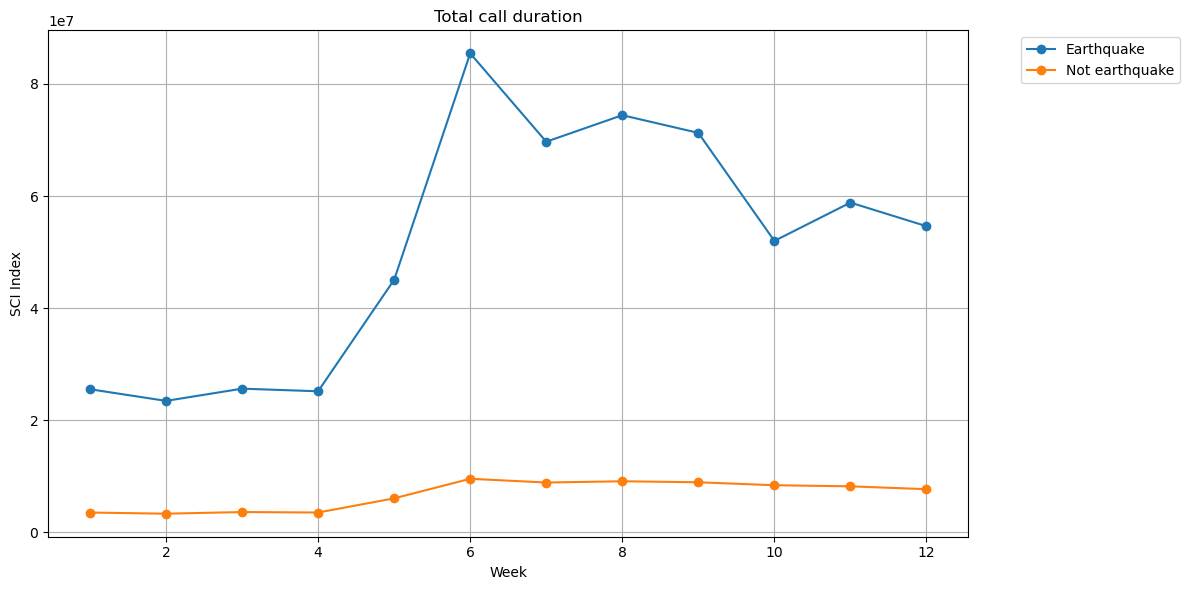

In [19]:
# Assuming 'earthquake_cities' is a list of city IDs affected by an earthquake
tr = antenna_social2[(antenna_social2["city_id_caller"].isin(earthquake_cities))].reset_index(drop=True)
sr = antenna_social2[~(antenna_social2["city_id_caller"].isin(earthquake_cities))].reset_index(drop=True)

# Setting up the plot
plt.figure(figsize=(12, 6))

# Plotting EI Index for earthquake cities
plt.plot(tr.groupby(['week'])['week'].mean(), tr.groupby(['week'])['sci'].mean(), marker='o', label="Earthquake")
plt.plot(sr.groupby(['week'])['week'].mean(), sr.groupby(['week'])['sci'].mean(), marker='o', label="Not earthquake")


plt.title('Total call duration')
plt.xlabel('Week')
plt.ylabel('SCI Index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


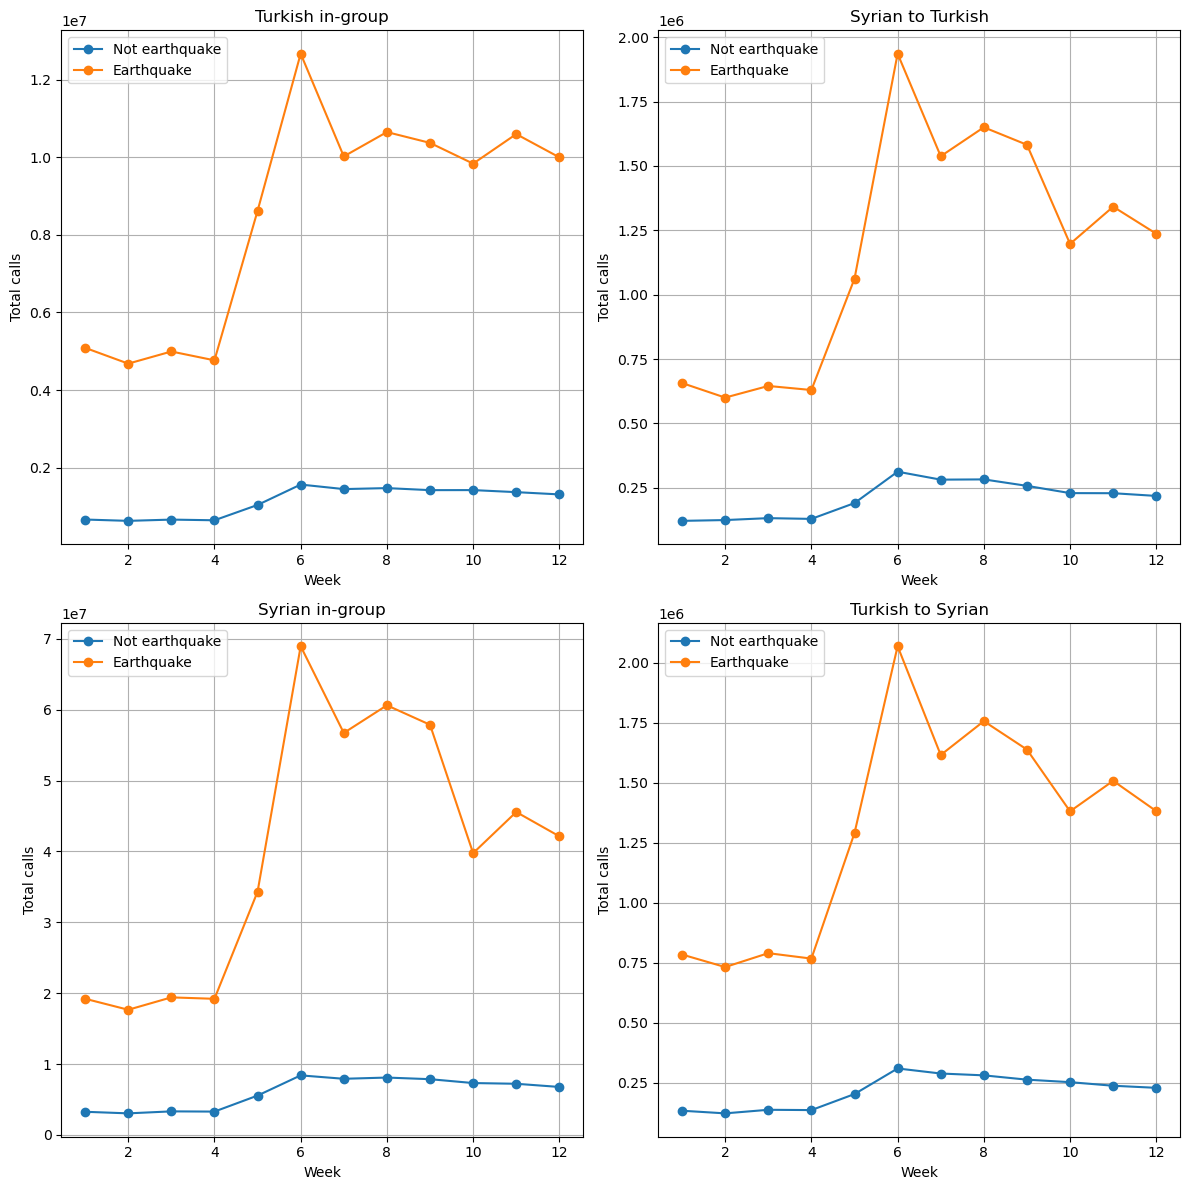

In [26]:
import matplotlib.pyplot as plt

tr1 = antenna_social[(antenna_social["segment_caller_callee"]=="1-1")&(antenna_social["city_id_caller"].isin(earthquake_cities)==False)].reset_index(drop=True)
tr2 = antenna_social[(antenna_social["segment_caller_callee"]=="2-1")&(antenna_social["city_id_caller"].isin(earthquake_cities)==False)].reset_index(drop=True)
tr3 = antenna_social[(antenna_social["segment_caller_callee"]=="2-2")&(antenna_social["city_id_caller"].isin(earthquake_cities)==False)].reset_index(drop=True)
tr4 = antenna_social[(antenna_social["segment_caller_callee"]=="1-2")&(antenna_social["city_id_caller"].isin(earthquake_cities)==False)].reset_index(drop=True)
#tr5 = antenna_social[antenna_social["segment_caller_callee"]=="0-1"].reset_index(drop=True)
#tr6 = antenna_social[antenna_social["segment_caller_callee"]=="0-2"].reset_index(drop=True)
tr1_2 = antenna_social[(antenna_social["segment_caller_callee"]=="1-1")&(antenna_social["city_id_caller"].isin(earthquake_cities)==True)].reset_index(drop=True)
tr2_2 = antenna_social[(antenna_social["segment_caller_callee"]=="2-1")&(antenna_social["city_id_caller"].isin(earthquake_cities)==True)].reset_index(drop=True)
tr3_2 = antenna_social[(antenna_social["segment_caller_callee"]=="2-2")&(antenna_social["city_id_caller"].isin(earthquake_cities)==True)].reset_index(drop=True)
tr4_2 = antenna_social[(antenna_social["segment_caller_callee"]=="1-2")&(antenna_social["city_id_caller"].isin(earthquake_cities)==True)].reset_index(drop=True)

# Assuming the data preparation part remains unchanged

# Setting up the 2x2 plot layout
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plotting each group in its subplot
axs[0, 0].plot(tr1.groupby(['week'])['week'].mean(), tr1.groupby(['week'])['total_call_duration_caller'].mean(), marker='o', label="Not earthquake")
axs[0, 0].plot(tr1_2.groupby(['week'])['week'].mean(), tr1_2.groupby(['week'])['total_call_duration_caller'].mean(), marker='o', label="Earthquake")

axs[0, 1].plot(tr2.groupby(['week'])['week'].mean(), tr2.groupby(['week'])['total_call_duration_caller'].mean(), marker='o', label="Not earthquake")
axs[0, 1].plot(tr2_2.groupby(['week'])['week'].mean(), tr2_2.groupby(['week'])['total_call_duration_caller'].mean(), marker='o', label="Earthquake")

axs[1, 0].plot(tr3.groupby(['week'])['week'].mean(), tr3.groupby(['week'])['total_call_duration_caller'].mean(), marker='o', label="Not earthquake")
axs[1, 0].plot(tr3_2.groupby(['week'])['week'].mean(), tr3_2.groupby(['week'])['total_call_duration_caller'].mean(), marker='o', label="Earthquake")

axs[1, 1].plot(tr4.groupby(['week'])['week'].mean(), tr4.groupby(['week'])['total_call_duration_caller'].mean(), marker='o', label="Not earthquake")
axs[1, 1].plot(tr4_2.groupby(['week'])['week'].mean(), tr4_2.groupby(['week'])['total_call_duration_caller'].mean(), marker='o', label="Earthquake")

#axs[2, 0].plot(tr5.groupby(['week'])['week'].mean(), tr5.groupby(['week'])['total_call_duration_caller'].mean(), marker='o', label="Turkish to Unknown")
#axs[2, 1].plot(tr6.groupby(['week'])['week'].mean(), tr6.groupby(['week'])['total_call_duration_caller'].mean(), marker='o', label="Syrian to Unknown")

# Setting titles, labels, and legends for each subplot
axs[0, 0].set_title('Turkish in-group')
axs[0, 0].set_xlabel('Week')
axs[0, 0].set_ylabel('Total calls')
axs[0, 0].legend(loc='upper left')
axs[0, 0].grid(True)

axs[0, 1].set_title('Syrian to Turkish')
axs[0, 1].set_xlabel('Week')
axs[0, 1].set_ylabel('Total calls')
axs[0, 1].legend(loc='upper left')
axs[0, 1].grid(True)

axs[1, 0].set_title('Syrian in-group')
axs[1, 0].set_xlabel('Week')
axs[1, 0].set_ylabel('Total calls')
axs[1, 0].legend(loc='upper left')
axs[1, 0].grid(True)

axs[1, 1].set_title('Turkish to Syrian')
axs[1, 1].set_xlabel('Week')
axs[1, 1].set_ylabel('Total calls')
axs[1, 1].legend(loc='upper left')
axs[1, 1].grid(True)


#axs[2, 0].set_title('Unknown to Syrian')
#axs[2, 0].set_xlabel('Week')
#axs[2, 0].set_ylabel('Total calls')
#axs[2, 0].legend(loc='upper left')
#axs[2, 0].grid(True)

#axs[2, 1].set_title('Unknown to Turkish')
#axs[2, 1].set_xlabel('Week')
#axs[2, 1].set_ylabel('Total calls')
#axs[2, 1].legend(loc='upper left')
#axs[2, 1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


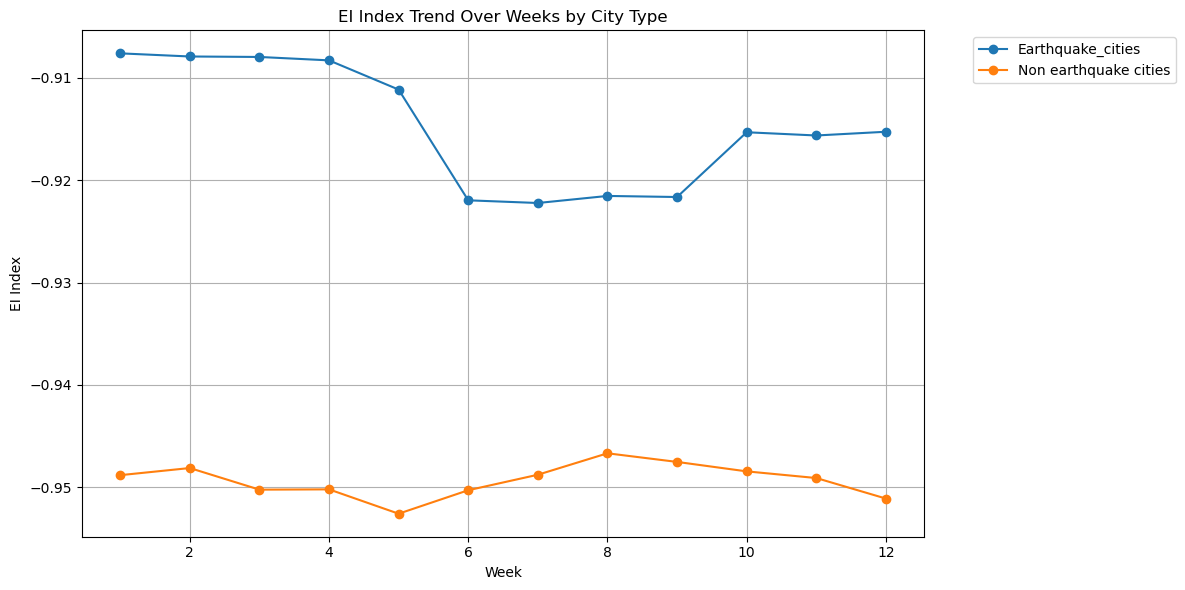

In [68]:
import matplotlib.pyplot as plt

# Assuming 'earthquake_cities' is a list of city IDs affected by an earthquake
earthquake_cities_data = ei[ei["city_id_caller"].isin(earthquake_cities)]
non_earthquake_cities_data = ei[~ei["city_id_caller"].isin(earthquake_cities)]

# Setting up the plot
plt.figure(figsize=(12, 6))

# Plotting EI Index for earthquake cities
plt.plot(earthquake_cities_data.groupby(['week'])['week'].mean(), earthquake_cities_data.groupby(['week'])['EI_index'].mean(), marker='o', label="Earthquake_cities")
plt.plot(non_earthquake_cities_data.groupby(['week'])['week'].mean(), non_earthquake_cities_data.groupby(['week'])['EI_index'].mean(), marker='o', label="Non earthquake cities")


plt.title('EI Index Trend Over Weeks by City Type')
plt.xlabel('Week')
plt.ylabel('EI Index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


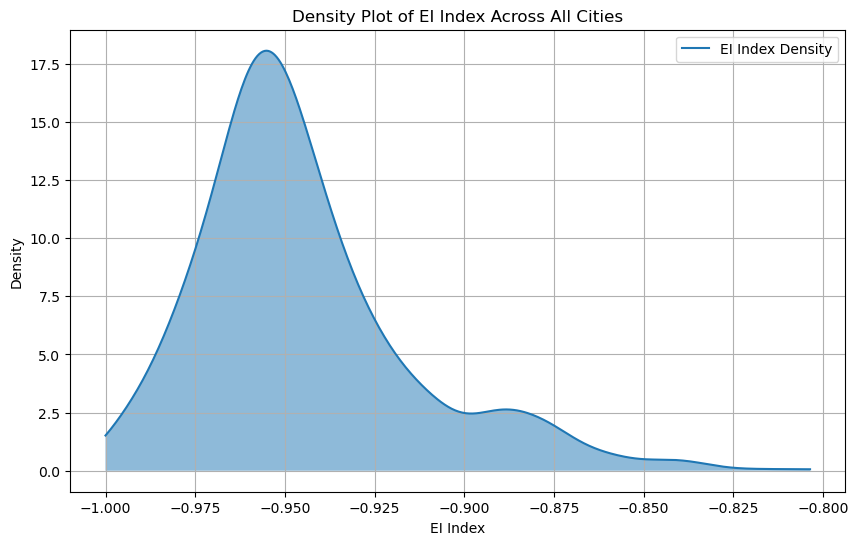

In [56]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# Extract EI_index values
ei_index_values = ei['EI_index'].values

# Calculate the KDE
ei_index_density = gaussian_kde(ei_index_values)

# Set up a range of EI_index values for plotting the density
ei_index_range = np.linspace(min(ei_index_values), max(ei_index_values), 400)

# Calculate the density for each value in the range
ei_index_pdf = ei_index_density(ei_index_range)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ei_index_range, ei_index_pdf, label='EI Index Density')
plt.fill_between(ei_index_range, ei_index_pdf, alpha=0.5)

plt.title('Density Plot of EI Index Across All Cities')
plt.xlabel('EI Index')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


<h1> FINE GRAINED

In [2]:
file_pat_in="/Volumes/Extreme Pro/Data-CDR/Incoming/Fine_grained/INC_FGM{}.txt"
file_path_out="/Volumes/Extreme Pro/Data-CDR/Outgoing/Fine_grained/FGM_{}.txt"

In [3]:
x=["7","7_2"]
df=pd.DataFrame()
for i in x: 
    df_in=process_fine_grained(file_pat_in.format(i),'INCOMING',tower_location)#.rename(columns={'customer_id':'callee_id'})
    df_out=process_fine_grained(file_path_out.format(i),'OUTGOING',tower_location)#.rename(columns={'customer_id':'caller_id'})
    df_in['call_type']='1'
    df_out['call_type']='0'
    df_merged=pd.concat([df_in,df_out]).reset_index(drop=True)
    df = pd.concat([df, df_merged], ignore_index=True)
    
df.reset_index(drop=True, inplace=True)

In [ ]:
df['caller_id'] = np.where(df['call_type'] == "0", df['customer_id'], np.nan)
df['callee_id'] = np.where(df['call_type'] == "1", df['customer_id'], np.nan)


<h1> SOCIAL INDICATORS

In [4]:
def calculate_segment_ratios(df):
    df_processed=df.copy()
    # Fill NaN values in 'segment_caller' and 'segment_callee' with 0 (representing unknown segment)
    df_processed['segment_caller'].fillna(0, inplace=True)
    df_processed['segment_callee'].fillna(0, inplace=True)
    
    # Create a new column to store the relevant segment based on call type
    df_processed['relevant_segment'] = np.where(df_processed['call_type'] == 1, df_processed['segment_caller'], df_processed['segment_callee'])
    
    # Count the number of calls per relevant segment for each customer
    segment_counts = df_processed.groupby(['customer_id', 'relevant_segment'])['call_type'].count().unstack(fill_value=0)
    
    # Calculate the total number of calls per customer
    total_calls = segment_counts.sum(axis=1)
    
    # Calculate the ratio of calls for each segment per customer
    segment_ratios = segment_counts.div(total_calls, axis=0)
    
    # Rename columns to 'call_ratio_seg_X'
    segment_ratios.columns = ['call_ratio_seg_' + str(int(col)) for col in segment_ratios.columns]
    del(df_processed)
    return segment_ratios.reset_index()

s=calculate_segment_ratios(df)

In [11]:
#l=read_tower_data(tower_location)[['city','city_id']].drop_duplicates(subset='city_id')
s.to_csv('/Volumes/Extreme Pro/calculated_indicators/segment_ratio.csv')

In [6]:
def calculate_unique_city_counts(df):
    unique_customer_ids = df['customer_id'].unique()
    chunk_size = len(unique_customer_ids) // 4  # Aim for 4 chunks; adjust based on your data size/preferences

    # Placeholder for results from each chunk
    results = []

    for start_idx in range(0, len(unique_customer_ids), chunk_size):
        end_idx = start_idx + chunk_size
        customer_ids_chunk = unique_customer_ids[start_idx:end_idx]

        # Filter the DataFrame for the current chunk of customer IDs
        df_chunk = df[df['customer_id'].isin(customer_ids_chunk)]

        # Process each chunk using vectorized operations
        df_chunk['customer_city'] = np.where(df_chunk['call_type'] == 1, df_chunk['city_id_callee'], df_chunk['city_id_caller'])
        df_chunk['other_party_city'] = np.where(df_chunk['call_type'] == 1, df_chunk['city_id_caller'], df_chunk['city_id_callee'])
        df_chunk = df_chunk.dropna(subset=['customer_city', 'other_party_city'], how='all')

        # Calculate unique counts for the chunk
        customer_city_count = df_chunk.groupby('customer_id')['customer_city'].nunique()
        other_party_city_count = df_chunk.groupby('customer_id')['other_party_city'].nunique()

        # Combine the counts into a single DataFrame for the chunk
        city_counts_chunk = pd.concat([customer_city_count, other_party_city_count], axis=1).reset_index()
        city_counts_chunk.columns = ['customer_id', 'cities_been_to_count', 'cities_in_communication_count']

        # Append chunk results to the results list
        results.append(city_counts_chunk)

    # Concatenate all chunk results into a single DataFrame
    city_counts_final = pd.concat(results).reset_index(drop=True)

    return city_counts_final

# Example usage
c = calculate_unique_city_counts(df)
c


/var/folders/f9/d5p3fn_51vzbn226fcn8ytx80000gn/T/ipykernel_5487/1093029477.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['customer_city'] = np.where(df_chunk['call_type'] == 1, df_chunk['city_id_callee'], df_chunk['city_id_caller'])
/var/folders/f9/d5p3fn_51vzbn226fcn8ytx80000gn/T/ipykernel_5487/1093029477.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['other_party_city'] = np.where(df_chunk['call_type'] == 1, df_chunk['city_id_caller'], df_chunk['city_id_callee'])
/var/folder

,customer_id,cities_been_to_count,cities_in_communication_count
0,100000697,23,1
1,100002132,22,1
2,100002165,28,1
3,100005723,13,1
4,100006682,18,1
...,...,...,...
278874,199995883,1,12
278875,199996087,8,1
278876,199999507,2,12
278877,199999943,10,2


In [12]:
c.to_csv('/Volumes/Extreme Pro/calculated_indicators/calculate_unique_city_counts.csv')#np.corrcoef(c['cities_been_to_count'],c['call_ratio_seg_1'])

<Axes: >

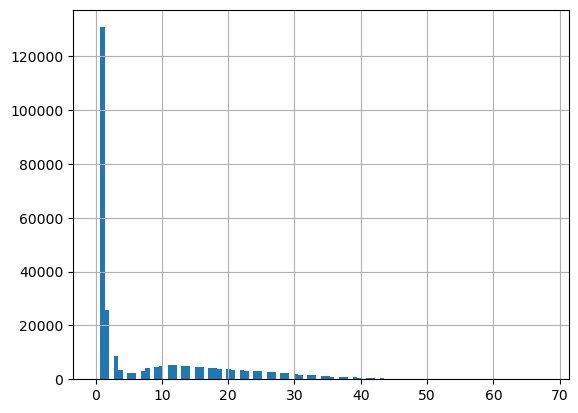

In [10]:
c['cities_been_to_count'].hist(bins=100)

In [13]:
def contact_diversity(df):
    # Assuming correct segment information is aligned with 'customer_id'
    diversity = df.groupby('customer_id').agg({'segment_caller': pd.Series.nunique})
    diversity.rename(columns={'segment_caller': 'segment_diversity'}, inplace=True)
    return diversity
d=contact_diversity(df)

In [15]:
d.reset_index().to_csv('/Volumes/Extreme Pro/calculated_indicators/segment_diversity.csv')

In [34]:
from collections import defaultdict

def calculate_degree_centrality_vectorized(df):

    # Initialize centrality as a Series to keep track of counts per caller_id or callee_id
    centrality_caller = df[df['call_type'] == "0"].groupby('caller_id').size()
    centrality_callee = df[df['call_type'] == "1"].groupby('callee_id').size()
    
    # Combine both Series, summing counts for caller_ids and callee_ids
    centrality = centrality_caller.add(centrality_callee, fill_value=0)
    
    # Convert to a dictionary (if needed)
    centrality_dict = centrality.to_dict()
    centrality_caller_dict = centrality_caller.to_dict()
    centrality_callee_dict = centrality_callee.to_dict()
    return centrality_dict,centrality_caller_dict,centrality_callee_dict

In [35]:
centrality,centrality_caller_dict,centrality_callee_dict = calculate_degree_centrality_vectorized(df)
centrality_df = pd.DataFrame(list(centrality.items()), columns=['customer_id', 'sum_of_calls'])
centrality_callee_df = pd.DataFrame(list(centrality_callee_dict.items()), columns=['customer_id', 'sum_of_incoming_calls'])
centrality_caller_df = pd.DataFrame(list(centrality_caller_dict.items()), columns=['customer_id', 'sum_of_outgoing_calls'])



In [41]:
centrality_df.merge(centrality_callee_df,on="customer_id",how="left").merge(centrality_caller_df,on="customer_id",how="left").fillna(0).to_csv("/Volumes/Extreme Pro/calculated_indicators/sum_of_calls.csv")

<h1> MOBILITY PATTERNS

In [ ]:
df=gpd.GeoDataFrame(df,geometry='geometry_caller')